# Introduction

La détection des points caractéristiques du visage d'une personne est l'une des applications les plus intéressantes de la vision par ordinateur, car ça permet de déduire beaucoup plus d'informations sur la personne (son âge, ses émotions ...).

L'objectif de ce projet est de créer un détecteur de caractéristiques d'un visage.

# Data Preparation

Le jeu de données complet contient des milliers d'images.
Le CPU de mon ordinateur ne peut pas traité toutes ces images, je vais donc me limiter à 2200 images.

* 2000 images pour l'entrainement.
* 200 images pour le test.

Je vais commencer donc par créer mon jeu de données.

**Remarque :** le jeu de données complet contient quelques images en double, je vais retirer les doublons.

In [1]:
import os

# Create the dataset folder
os.makedirs("./dataset/images", exist_ok=True)

In [2]:
import shutil
from config import *
import xml.etree.ElementTree as ET


to_keep = []    # list of images to keep
kept = []       # image_num of images kept 

mytree = ET.parse(LABELS_XML_FILEPATH)
myroot = mytree.getroot()
images = myroot.find('images').findall("image")

# Only keep 2200 images.
for image in images:
    fname = image.get("file")
    fpath = os.path.join(FULL_DATASET_PATH, fname)
    image_name = fname.split("/")[-1]
    image_num = fname.split("_")[0]
    if image_num not in kept: # avoid keeping doubles.
        new_fname = os.path.join("./images", image_name)
        new_fpath = os.path.join(DATASET_PATH, new_fname)
        image.set("file", new_fname)
        shutil.copy(fpath, new_fpath)

        kept.append(image_num)
        to_keep.append(image)

    if len(to_keep) == NB_IMAGES: break

# split the 2200 images into training & testing images.
train_images = to_keep[:NB_TRAIN_IMAGES]
test_images = to_keep[NB_TRAIN_IMAGES:]

In [3]:
import xml.etree.ElementTree as gfg 
import os 


# Create & save the xml file.
def create_xml(images, filepath):
    root = gfg.Element("dataset")

    imgs_xml = gfg.Element("images")
    for image in images:
        imgs_xml.append(image)

    root.append(imgs_xml)
    tree = gfg.ElementTree(root)
        
    with open (filepath, "wb") as files :
        tree.write(files)

# Create & save the train.xml file
create_xml(train_images, TRAIN_XML_FILEPATH)

# Create & save the test.xml file
create_xml(test_images, TEST_XML_FILEPATH)

# Model

In [1]:
from utils import rect_to_bbox, shape_to_np
import matplotlib.pyplot as plt
import multiprocessing
import cv2, dlib

#### Define the model parameters

In [5]:
# grab the default options for dlib's shape predictor
options = dlib.shape_predictor_training_options()

# define the depth of each regression tree -- there will be a total
# of 2^tree_depth leaves in each tree; small values of tree_depth
# will be *faster* but *less accurate* while larger values will
# generate trees that are *deeper*, *more accurate*, but will run
# *far slower* when making predictions
options.tree_depth = 4

# regularization parameter in the range [0, 1] that is used to help
# our model generalize -- values closer to 1 will make our model fit
# the training data better, but could cause overfitting; values closer
# to 0 will help our model generalize but will require us to have
# training data in the order of 1000s of data points
options.nu = 0.1

# the number of cascades used to train the shape predictor -- this
# parameter has a *dramtic* impact on both the *accuracy* and *output
# size* of your model; the more cascades you have, the more accurate
# your model can potentially be, but also the *larger* the output size
options.cascade_depth = 15

# number of pixels used to generate features for the random trees at
# each cascade -- larger pixel values will make your shape predictor
# more accurate, but slower; use large values if speed is not a
# problem, otherwise smaller values for resource constrained/embedded
# devices
options.feature_pool_size = 400

# selects best features at each cascade when training -- the larger
# this value is, the *longer* it will take to train but (potentially)
# the more *accurate* your model will be
options.num_test_splits = 50

# controls amount of "jitter" (i.e., data augmentation) when training
# the shape predictor -- applies the supplied number of random
# deformations, thereby performing regularization and increasing the
# ability of our model to generalize
options.oversampling_amount = 5

# amount of translation jitter to apply -- the dlib docs recommend
# values in the range [0, 0.5]
options.oversampling_translation_jitter = 0.1

# tell the dlib shape predictor to be verbose and print out status
# messages our model trains
options.be_verbose = True

# number of threads/CPU cores to be used when training -- we default
# this value to the number of available cores on the system, but you
# can supply an integer value here if you would like
options.num_threads = multiprocessing.cpu_count()

#### Train the model

In [6]:
dlib.train_shape_predictor(TRAIN_XML_FILEPATH, OUTPUT_MODEL_PATH, options)

Training with cascade depth: 15
Training with tree depth: 4
Training with 500 trees per cascade level.
Training with nu: 0.1
Training with random seed: 
Training with oversampling amount: 5
Training with oversampling translation jitter: 0.1
Training with landmark_relative_padding_mode: 1
Training with feature pool size: 400
Training with feature pool region padding: 0
Training with 8 threads.
Training with lambda_param: 0.1
Training with 50 split tests.
Fitting trees...
Progress: 7484/7500 (99.79%). Time remaining: 1 seconds.                    gress: 457/7500 (6.09%). Time remaining: 5.92 minutes.                 
Training complete
Training complete, saved predictor to file ./output_model.dat


#### Test the model

In [7]:
# The real test is to see how well it does on data it wasn't trained on.  We
# trained it on a very small dataset so the accuracy is not extremely high, but
# it's still doing quite good.  Moreover, if you train it on one of the large
# face landmarking datasets you will obtain state-of-the-art results, as shown
# in the Kazemi paper.
mae = dlib.test_shape_predictor(TEST_XML_FILEPATH, "output_model.dat")
print("Mean average error: {}".format(mae))

Mean average error: 17.41907900112489


# Visualize Model Performance

Pour faire la détéction des **Facial Landmarks** nous avons besoin de commencer par détécter les visages.

Mais puisque l'objectif de ce projet n'est pas la détéction des visages, alors nous pouvons utilisé le modèle de détéction de visage fournie par **dlib** ou bien utiliser celui que j'ai entrainé dans un autre projet (**FaceDetector**).

Dans la suite, je vais utiliser le modèle pre-entrainé par **dlib**.

In [2]:
# initialize dlib's face detector
detector = dlib.get_frontal_face_detector()

# Create the facial landmark predictor
predictor = dlib.shape_predictor("./output_model.dat")

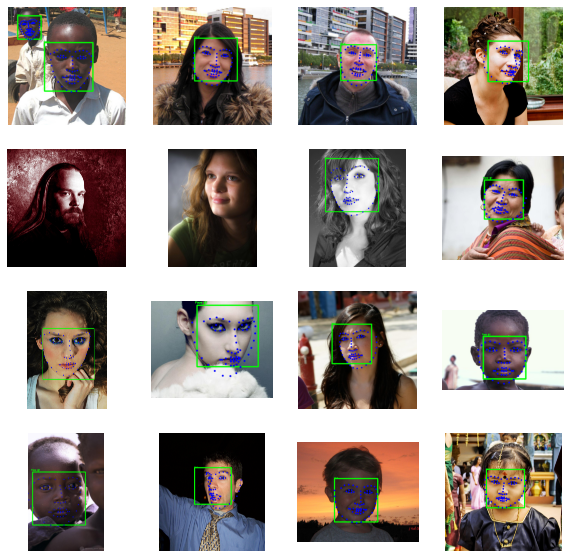

In [12]:
mytree = ET.parse(TEST_XML_FILEPATH)
myroot = mytree.getroot()
images = myroot.find('images').findall("image")

fig, axes = plt.subplots(4, 4, figsize = (10,10))
axes = axes.flatten()
for idx in range(16):
    image = images[idx]
    fpath = os.path.join(DATASET_PATH, image.get('file'))
    image = cv2.imread(fpath)
    height, width, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rectangles = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rectangles):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(image, rect)
        shape = shape_to_np(shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (xmin, ymin, xmax, ymax) = rect_to_bbox(rect)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), width//100)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (xmin - 10, ymin - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), width//80)
    # show the output image with the face detections + facial landmarks
    ax = axes[idx]
    ax.imshow(image)
    ax.set_axis_off()
plt.show()

# Inference

In [3]:
from imutils.video import VideoStream
import time, cv2

cap = cv2.VideoCapture(0)

In [4]:
ret, image = cap.read()
height, width = image.shape[0], image.shape[1]

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('video.avi', fourcc, 20, (width, height))

In [ ]:
from time import time

# loop over the frames from the video stream
t = time()
while time() < t + 120:
	# grab the frame from the video stream, resize it to have a
	# maximum width of 400 pixels, and convert it to grayscale
	ret, image = cap.read()
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	# detect faces in the grayscale frame
	rects = detector(gray, 0)
    # loop over the face detections
	# loop over the face detections
	for i, rect in enumerate(rects):
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = shape_to_np(shape)
		# convert dlib's rectangle to a OpenCV-style bounding box
		# [i.e., (x, y, w, h)], then draw the face bounding box
		(xmin, ymin, xmax, ymax) = rect_to_bbox(rect)
		cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
		# show the face number
		cv2.putText(image, "Face #{}".format(i + 1), (xmin - 10, ymin - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
		# loop over the (x, y)-coordinates for the facial landmarks
		# and draw them on the image
		for (x, y) in shape:
			cv2.circle(image, (x, y), 1, (0, 0, 255), 3)
	# show the frame
	cv2.imshow("Frame", image)
	key = cv2.waitKey(1) & 0xFF
	# save the frame into video
	height, width = image.shape[0], image.shape[1]
	if ret:
		video.write(image)
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
# do a bit of cleanup
cv2.destroyAllWindows()
cap.release()